In [1]:
from main import *
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import copy
import skimage
from skimage.segmentation import quickshift,slic,mark_boundaries

Device: cpu


### Adversarial example generation 

In [2]:
# data_config = parse_data_config(DATA_CONFIG_PATH)
valid_path_adv = os.path.join(ROOT_DIR, "sample/sample_path.txt")
# class_names = load_classes(data_config["names"])
# print('the classes in the label',class_names)
###############################################################################
net = Darknet(MODEL_DEF).to(device)
if PRETRAINED_WEIGHTS:
    if PRETRAINED_WEIGHTS.endswith(".pth"):
        net.load_state_dict(torch.load(PRETRAINED_WEIGHTS, map_location=device))
    else:
        net.load_darknet_weights(PRETRAINED_WEIGHTS)
else:
    net.apply(weights_init_normal)
attack = FastGradientSignMethod(model = net, epsilon = 0.2, min_val=0, max_val=1)
adv_data, diff, data = generate_attacks(net, valid_path_adv, num_epochs=1, batch_size=1, attack=attack)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


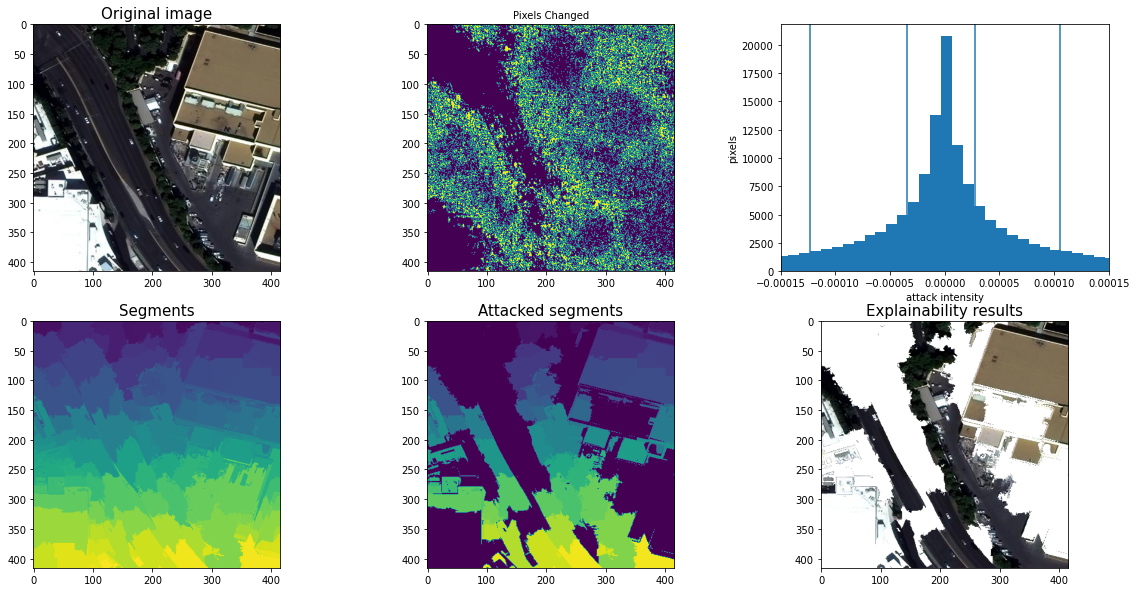

In [3]:
# check any sample image
index=1

# thresholding attack intensity
dif_1=copy.deepcopy(diff[index][0]) 
dif_2=copy.deepcopy(diff[index][1])
dif_3=copy.deepcopy(diff[index][2])
dif_total = dif_1

thres1=np.percentile(dif_1, 15)
thres2=np.percentile(dif_1, 30)
thres3=np.percentile(dif_1, 70)
thres4=np.percentile(dif_1, 85)

fig = plt.figure(figsize=(20,10))
ax3 = fig.add_subplot(2, 3, 3)
_ = ax3.hist(dif_total.reshape(-1), bins=1000)
ax3.set_xlabel('attack intensity')
ax3.set_ylabel('pixels')
ax3.axvline(x=thres1)
ax3.axvline(x=thres2)
ax3.axvline(x=thres3)
ax3.axvline(x=thres4)
ax3.set_xlim(xmin=-0.00015, xmax = 0.00015)

mask1 = dif_total < thres1
mask2 = (dif_total >= thres1) & (dif_total < thres2)
mask3 = (dif_total >= thres2) & (dif_total < thres3)
mask4 = (dif_total >= thres3) & (dif_total < thres4)
mask5 = dif_total >= thres4
dif_total[mask1] = 0
dif_total[mask2] = 1
dif_total[mask3] = 0
dif_total[mask4] = 1
dif_total[mask5] = 0

# segmenting image
original_image = copy.deepcopy(data[index]) 
image = np.transpose(original_image, (1, 2, 0)).astype('double')
segments_orig = skimage.segmentation.quickshift(image, kernel_size=5, max_dist=20, ratio=0.9)
# segments_orig = skimage.segmentation.quickshift(image, kernel_size=8, max_dist=200, ratio=0.9)

# thresholding attack density
values, counts = np.unique(segments_orig, return_counts=True)
att_3_filter = dif_total
attack_frequency=[]
attack_intensity=[]
    
for i in range(len(values)):
    segments_orig_loc=segments_orig==values[i]
    tmp = np.logical_and(segments_orig_loc,att_3_filter)
    attack_frequency.append(np.sum(tmp))
    attack_intensity.append(np.sum(tmp)/counts[i])
attack_intensity=np.array(attack_intensity)

intensity_thres=50
intensity_filter = attack_intensity>np.percentile(attack_intensity, intensity_thres)
strongly_attacked_list = values[intensity_filter]
un_slightly_attacked_list = np.delete(values, strongly_attacked_list)

strongly_attacked_image = copy.deepcopy(image)
strongly_attacked_segments = copy.deepcopy(segments_orig)
for x in un_slightly_attacked_list:
    strongly_attacked_image[segments_orig == x] = (255,255,255)
    strongly_attacked_segments[segments_orig == x] = 0

# show
ax1 = fig.add_subplot(2, 3, 1)
ax1.set_title('Original image',fontsize= 15)
ax1.imshow(np.transpose(data[index], (1,2,0)))

ax2 = fig.add_subplot(2, 3, 2)
ax2.set_title('Pixels Changed',fontsize= 10)
ax2.imshow(dif_total)


ax4 = fig.add_subplot(2, 3, 4)
# ax2.set_title("Segments, num: {}".format(len(values)),fontsize= 15)
ax4.set_title("Segments",fontsize= 15)
ax4.imshow(segments_orig)

ax5 = fig.add_subplot(2, 3, 5)
# ax3.set_title('attacked segments',fontsize= 10)
ax5.set_title("Attacked segments",fontsize= 15)
# ax3.set_title("attacked segments, num:{}".format(len(strongly_attacked_list)),fontsize= 15)
ax5.imshow(strongly_attacked_segments)

ax6 = fig.add_subplot(2, 3, 6)
ax6.set_title('Explainability results',fontsize= 15)
ax6.imshow(strongly_attacked_image)


plt.savefig("Demo.png")



